# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


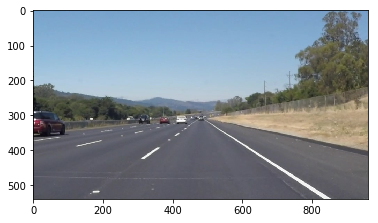

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

    `cv2.inRange()` for color selection  
    `cv2.fillPoly()` for regions selection  
    `cv2.line()` to draw lines on an image given endpoints  
    `cv2.addWeighted()` to coadd / overlay two images
    `cv2.cvtColor()` to grayscale or change color
    `cv2.imwrite()` to output images to file  
    `cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines_old(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)


last_slope_left = last_slope_right = last_intercept_left = last_intercept_right = 0
def reset_cache():
    global last_slope_left, last_slope_right, last_intercept_left, last_intercept_right
    last_slope_left = last_slope_right = last_intercept_left = last_intercept_right = 0
            
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    slope_left = []  # [slope, ...]
    intercept_left = []  # [intercept, ...]
    slope_right = []
    intercept_right = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - slope * x1
            if slope < 0:  # The Y = 0 is on the top, so we should reverse the slope.
                slope_left.append(slope)
                intercept_left.append(intercept)
            else:
                slope_right.append(slope)
                intercept_right.append(intercept)
    # Calculate the average slope and intercept.
    avg_slope_left = np.median(slope_left)
    avg_intercept_left = np.median(intercept_left)
    avg_slope_right = np.median(slope_right)
    avg_intercept_right = np.median(intercept_right)
    # Smooth the line using the cached results.
    global last_slope_left, last_slope_right, last_intercept_left, last_intercept_right
    if last_slope_left == 0:
        history_weight = 0
    else:
        history_weight = 0.5
    avg_slope_left = last_slope_left * history_weight + avg_slope_left * (1 - history_weight)
    avg_slope_right = last_slope_right * history_weight + avg_slope_right * (1 - history_weight)
    avg_intercept_left = last_intercept_left * history_weight + avg_intercept_left * (1 - history_weight)
    avg_intercept_right = last_intercept_right * history_weight + avg_intercept_right * (1 - history_weight)
    last_slope_left = avg_slope_left
    last_slope_right = avg_slope_right
    last_intercept_left = avg_intercept_left
    last_intercept_right = avg_intercept_right
    
    # Calculate the cross point of two lines.
    cross_x = (avg_intercept_right - avg_intercept_left) / (avg_slope_left - avg_slope_right)
    cross_y = avg_slope_left * cross_x + avg_intercept_left
    # Break the cross so it looks more like the example.
    cross_y = cross_y + thickness
    cross_x_left = (cross_y - avg_intercept_left) / avg_slope_left
    cross_x_right = (cross_y - avg_intercept_right) / avg_slope_right
    
    # Calculate the points on edges.
    bottom_y = 539
    bottom_x_left = (bottom_y - avg_intercept_left) / avg_slope_left
    bottom_x_right = (bottom_y - avg_intercept_right) / avg_slope_right
    # Add the left line in image.
    round_int = lambda x: int(round(x))
    cv2.line(img, (round_int(cross_x_left), round_int(cross_y)), (round_int(bottom_x_left), round_int(bottom_y)), color, thickness)
    cv2.line(img, (round_int(cross_x_right), round_int(cross_y)), (round_int(bottom_x_right), round_int(bottom_y)), color, thickness)
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, extrapolate=True):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]),
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    if not extrapolate:
        draw_lines_old(line_img, lines, color=[255, 0, 0], thickness=2)
    else:
        draw_lines(line_img, lines, thickness=10)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [4]:
def show(filename, size=6):
    if isinstance(filename, np.ndarray):
        image = filename
        print('This image dimensions:', image.shape)
    else:
        image = mpimg.imread(filename)
        print('This image is:', filename, 'with dimensions:', image.shape)
    fig = plt.figure(figsize=(size, size))
    ax = fig.add_subplot(1,1,1)

    if len(image.shape) == 2:
        print('show gray image.')
        ax.imshow(image, cmap='Greys_r')
    else:
        ax.imshow(image)
    plt.show()
    

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [5]:
import os
print(os.listdir("test_images/"))

test_files = []
for filename in os.listdir("test_images/"):
    test_files.append(os.path.join("test_images", filename))
    #show(test_files[-1])

['solidYellowCurve.jpg', 'solidYellowLeft.jpg', 'solidYellowCurve2.jpg', 'solidWhiteRight.jpg', 'whiteCarLaneSwitch.jpg', 'solidWhiteCurve.jpg']


## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

This image is: test_images/solidYellowCurve.jpg with dimensions: (540, 960, 3)


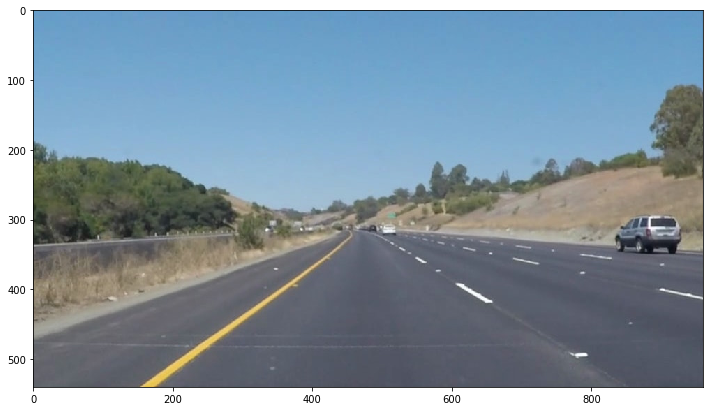

filename test_images/solidYellowCurve.jpg
This image dimensions: (540, 960)
show gray image.


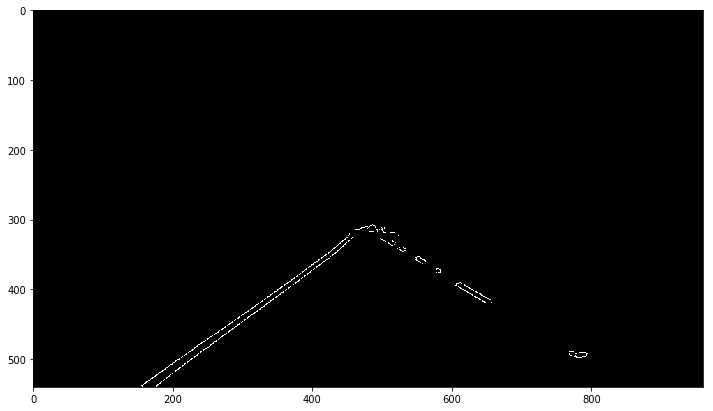

This image dimensions: (540, 960, 3)


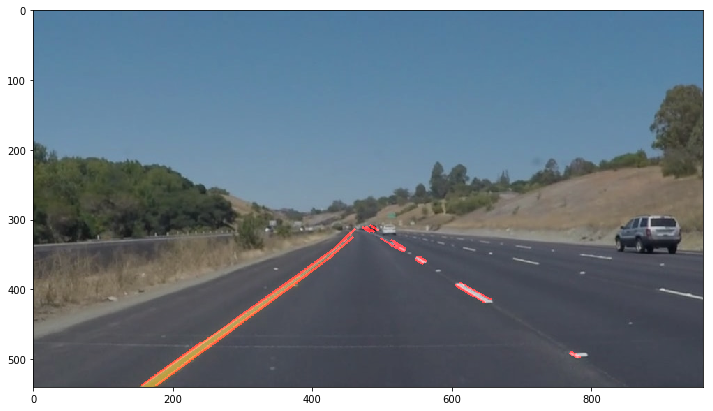

This image dimensions: (540, 960, 3)


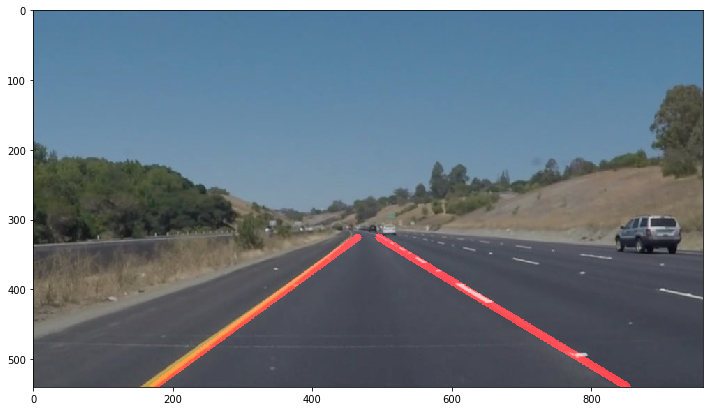

This image is: test_images/solidYellowLeft.jpg with dimensions: (540, 960, 3)


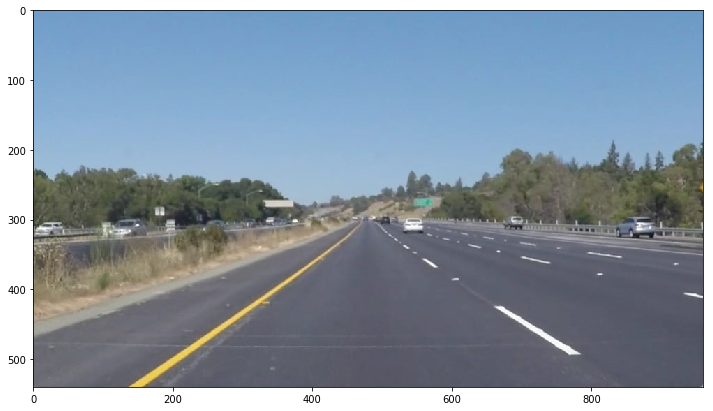

filename test_images/solidYellowLeft.jpg
This image dimensions: (540, 960)
show gray image.


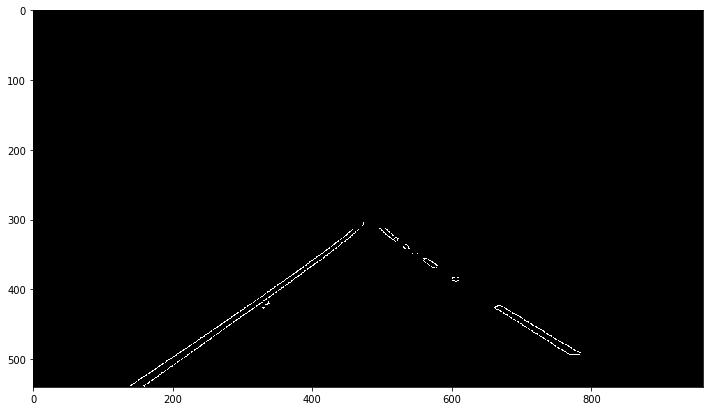

This image dimensions: (540, 960, 3)


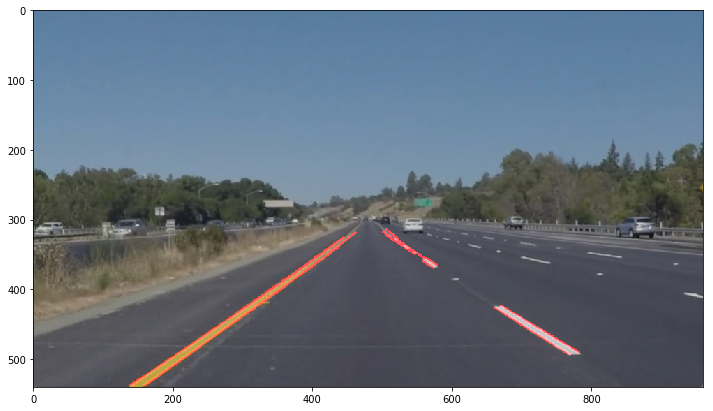

This image dimensions: (540, 960, 3)


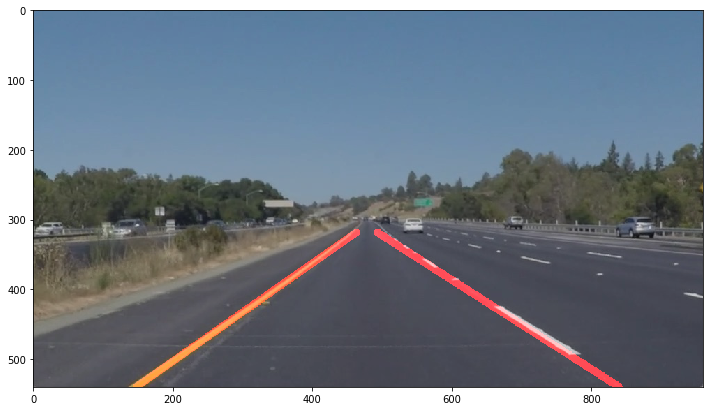

This image is: test_images/solidYellowCurve2.jpg with dimensions: (540, 960, 3)


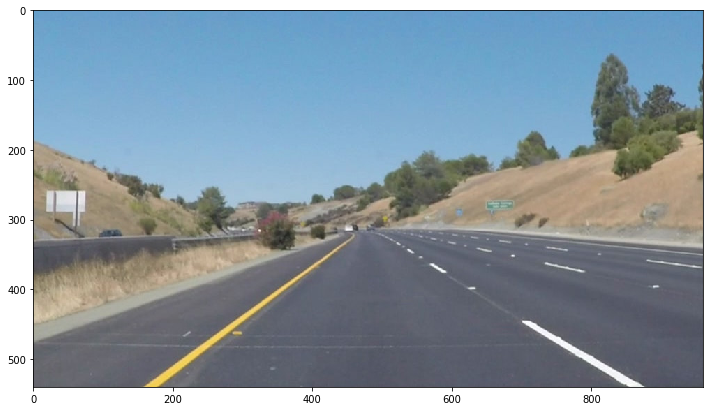

filename test_images/solidYellowCurve2.jpg
This image dimensions: (540, 960)
show gray image.


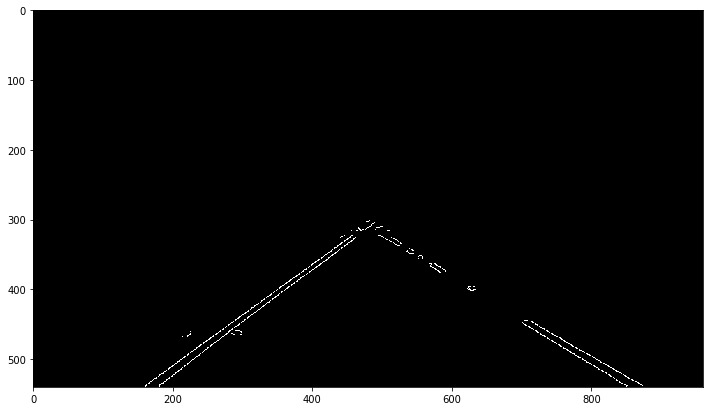

This image dimensions: (540, 960, 3)


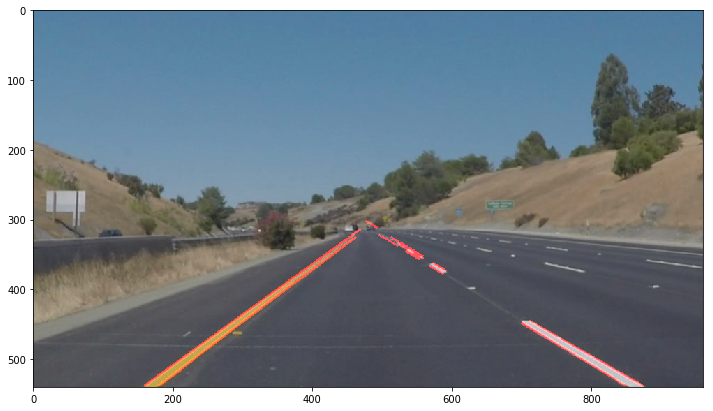

This image dimensions: (540, 960, 3)


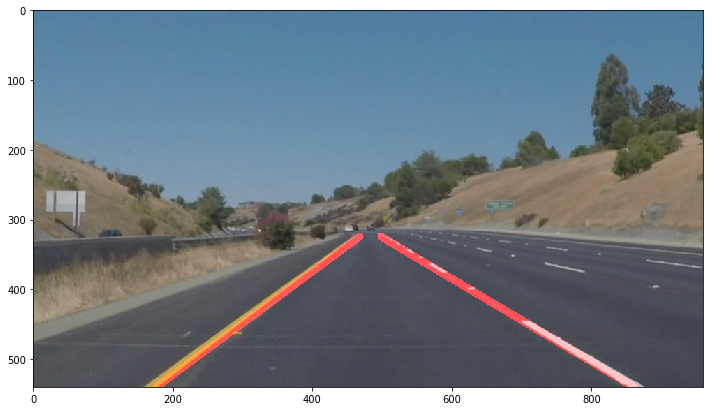

This image is: test_images/solidWhiteRight.jpg with dimensions: (540, 960, 3)


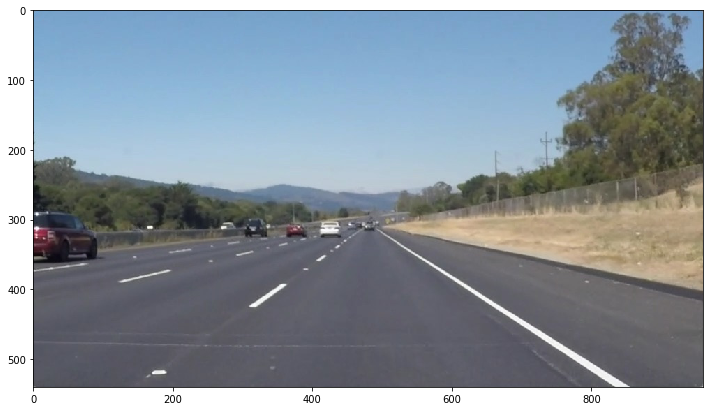

filename test_images/solidWhiteRight.jpg
This image dimensions: (540, 960)
show gray image.


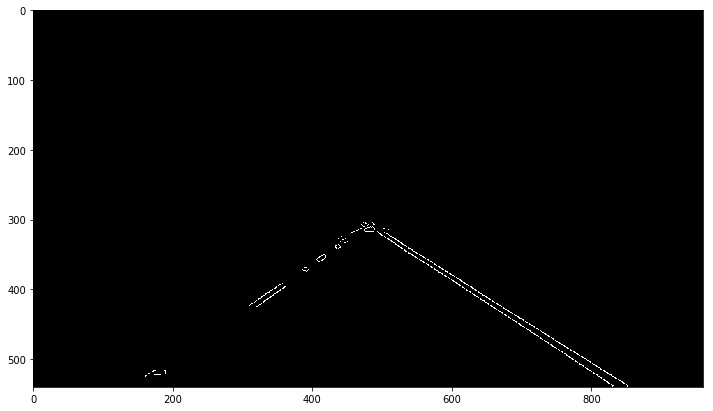

This image dimensions: (540, 960, 3)


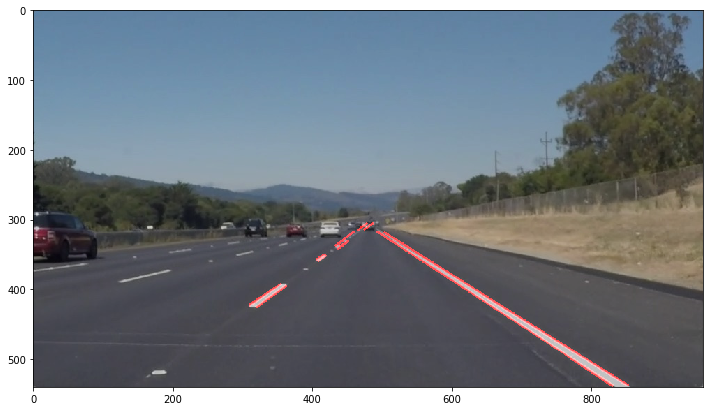

This image dimensions: (540, 960, 3)


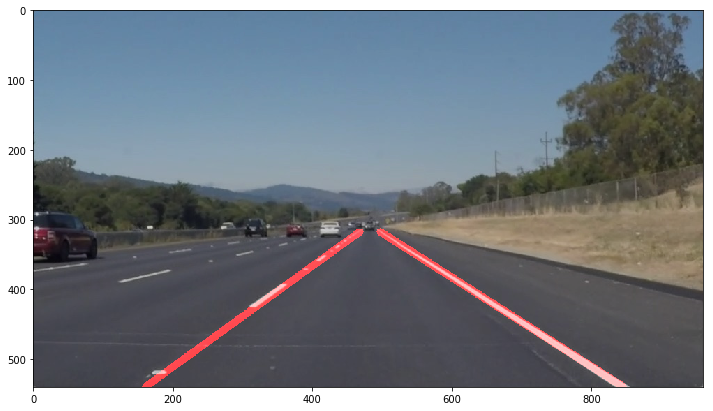

This image is: test_images/whiteCarLaneSwitch.jpg with dimensions: (540, 960, 3)


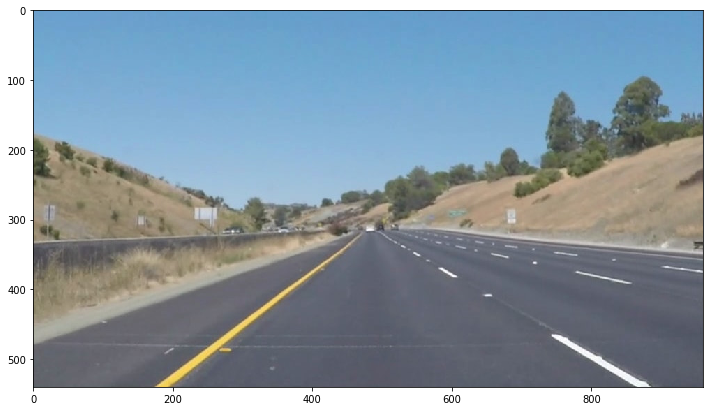

filename test_images/whiteCarLaneSwitch.jpg
This image dimensions: (540, 960)
show gray image.


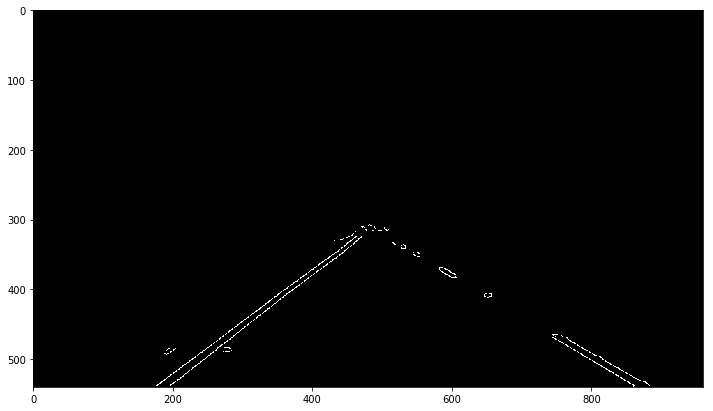

This image dimensions: (540, 960, 3)


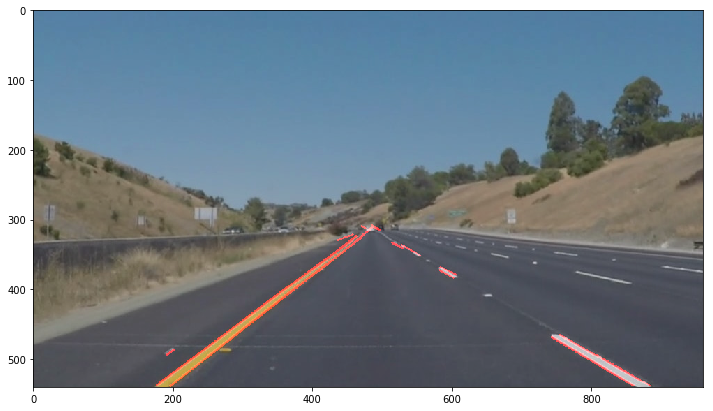

This image dimensions: (540, 960, 3)


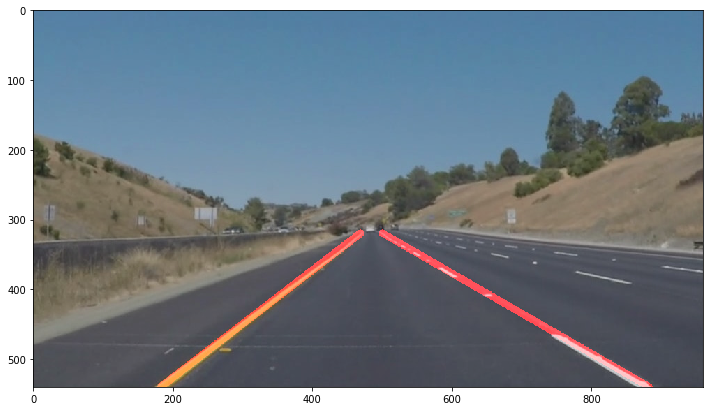

This image is: test_images/solidWhiteCurve.jpg with dimensions: (540, 960, 3)


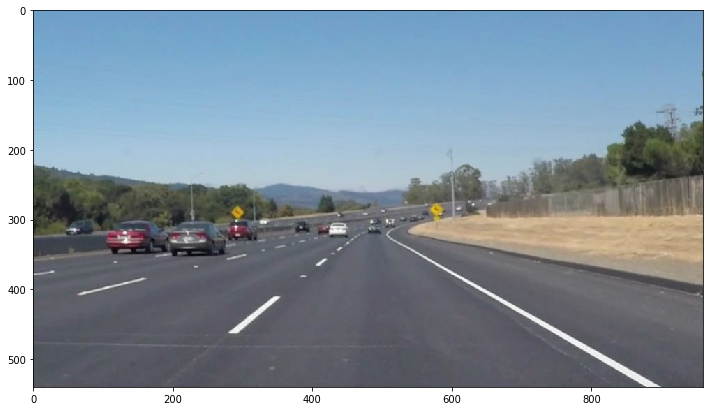

filename test_images/solidWhiteCurve.jpg
This image dimensions: (540, 960)
show gray image.


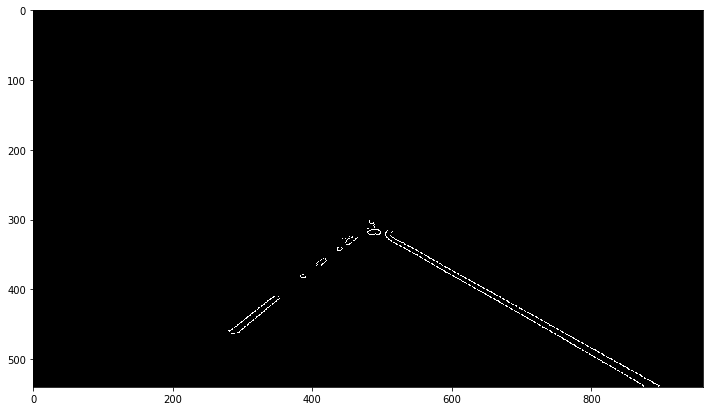

This image dimensions: (540, 960, 3)


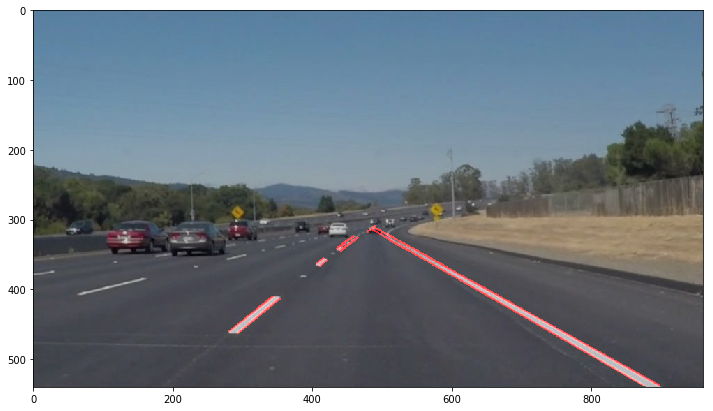

This image dimensions: (540, 960, 3)


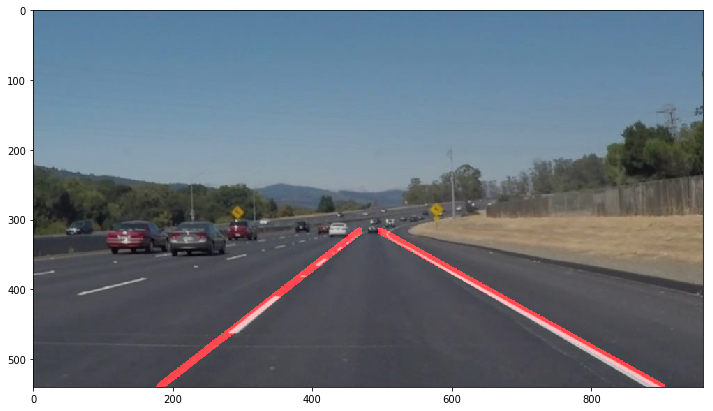

In [7]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

def select_region(image):
    left_bottom = [100, 539]
    right_bottom = [959, 539]
    apex = [480, 300]
    vertices = np.array([[left_bottom, right_bottom, apex]], dtype=np.int32)
    return region_of_interest(image, vertices)

def get_hough_lines(masked_edges, max_line_gap=10, extrapolate=True):
    rho = 1  # distance resolution in pixels
    theta = np.pi/180  # angular resolution in degree.
    threshold = 20  # minimum number of votes (intersections in a given grid cell) 
    min_line_length = 10  # minimum length of a line (in pixels) that you will accept in the output
    #max_line_gap = 10  # maximum distance in pixels between segments allowed to be connected into a single line.
    line_image = np.copy(image)*0 #creating a blank to draw lines on

    return hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap, extrapolate=extrapolate)
    

def find_lane(filename, size=12):
    show(filename, size=size)
    print('filename', filename)
    image = mpimg.imread(filename)
    
    gray = grayscale(image)
    if not os.path.exists('test_images_output'):
        os.mkdir('test_images_output')
    output_path = filename.replace('test_images', 'test_images_output')
    output_path = output_path.replace('.jpg', '_gray.jpg')
    cv2.imwrite(output_path, gray)

    kernel_size = 15
    blur_gray = gaussian_blur(gray, kernel_size)
    output_path = filename.replace('test_images', 'test_images_output')
    output_path = output_path.replace('.jpg', '_blur_gray.jpg')
    cv2.imwrite(output_path, blur_gray)
    #mpimg.imsave(output_path, blur_gray)
    
    low_threshold = 30
    high_threshold = 40
    edges = canny(blur_gray, low_threshold, high_threshold)
    output_path = filename.replace('test_images', 'test_images_output')
    output_path = output_path.replace('.jpg', '_canny.jpg')
    #mpimg.imsave(output_path, edges)
    cv2.imwrite(output_path, edges)
    
    masked_edges = select_region(edges)
    show(masked_edges, size=size)
    output_path = filename.replace('test_images', 'test_images_output')
    output_path = output_path.replace('.jpg', '_canny_masked.jpg')
    #mpimg.imsave(output_path, masked_edges)
    cv2.imwrite(output_path, masked_edges)
    
    reset_cache()
    lines = get_hough_lines(masked_edges, extrapolate=False)
    combined_image = weighted_img(lines, image)    
    show(combined_image, size=size)
    output_path = filename.replace('test_images', 'test_images_output')
    output_path = output_path.replace('.jpg', '_hough_lines.jpg')
    mpimg.imsave(output_path, combined_image)
    #cv2.imwrite(output_path, combined_image)
    
    reset_cache()
    lines = get_hough_lines(masked_edges, extrapolate=True)
    combined_image = weighted_img(lines, image)
    show(combined_image, size=size)
    output_path = filename.replace('test_images', 'test_images_output')
    output_path = output_path.replace('.jpg', '_extrapolated_lines.jpg')
    mpimg.imsave(output_path, combined_image)
    #cv2.imwrite(output_path, combined_image)
    
for filename in test_files:
    find_lane(filename)


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Imageio: 'ffmpeg.osx' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.osx (28.8 MB)
Downloading: 8192/30241064 bytes (0.0614400/30241064 bytes (2.01892352/30241064 bytes (6.3%3678208/30241064 bytes (12.25734400/30241064 bytes (19.07888896/30241064 bytes (26.19732096/30241064 bytes (32.212132352/30241064 bytes (40.1%13737984/30241064 bytes (45.4%16318464/30241064 bytes (54.0%17948672/30241064 bytes (59.4%20094976/30241064 bytes (66.4%21749760/30241064 bytes (71.9%25174016/30241064 bytes (83.2%27017216/30241064 bytes (89.3%28581888/30241064 bytes (94.5%30241064/30241064 bytes (100.0%)
  Done
File saved as /Users/jyang/Library/Application Support/imageio/ffmpeg/ffmpeg.osx.


In [9]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)   
    gray = grayscale(image)
    kernel_size = 15
    blur_gray = gaussian_blur(gray, kernel_size)
    
    low_threshold = 30
    high_threshold = 40
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    masked_edges = select_region(edges)
    lines = get_hough_lines(masked_edges, extrapolate=True)
    
    combined_image = weighted_img(lines, image)

    return combined_image

Let's try the one with the solid white lane on the right first ...

In [10]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:03<00:00, 70.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 1.71 s, sys: 176 ms, total: 1.88 s
Wall time: 3.65 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [12]:
reset_cache()
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:09<00:00, 69.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 5.22 s, sys: 506 ms, total: 5.72 s
Wall time: 10.3 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [14]:
def select_region_challenge(image):
    height, width = image.shape[:2]
    left_bottom = [200, height-80]
    right_bottom = [1050, height-80]
    left_apex = [600, 400]
    right_apex = [700, 400]
    vertices = np.array([[right_apex, left_apex, left_bottom, right_bottom]], dtype=np.int32)
    return region_of_interest(image, vertices)


def process_image_challenge(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)   
    gray = grayscale(image)
    kernel_size = 21
    blur_gray = gaussian_blur(gray, kernel_size)
    
    low_threshold = 30
    high_threshold = 50
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    masked_edges = select_region_challenge(edges)
    #show(masked_edges)
    lines = get_hough_lines(masked_edges, extrapolate=True)
    
    combined_image = weighted_img(lines, image)

    return combined_image

In [17]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,3)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image_challenge)
challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:07<00:00, 32.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 



In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

# **Finding Lane Lines on the Road** 

---

**Finding Lane Lines on the Road**

The goals / steps of this project are the following:
* Make a pipeline that finds lane lines on the road
* Reflect on your work in a written report


[//]: # (Image References)

[image1]: ./test_images_output/solidWhiteCurve_gray.jpg "Grayscale"

---

### Reflection

### 1. Describe your pipeline. As part of the description, explain how you modified the draw_lines() function.

My pipeline consisted of 6 steps.
  1. convert the images to grayscale.
  <img src="test_images_output/solidWhiteCurve_gray.jpg" width="380" alt="Gray Image" />
  1. apply gaussian blur with kernel size 15 on the gray image.
  <img src="test_images_output/solidWhiteCurve_blur_gray.jpg" width="380" alt="Blur Image" />
  1. apply canny edge detection with low_threshold=30 and high_threshold=40.
  <img src="test_images_output/solidWhiteCurve_canny.jpg" width="380" alt="Canny Image" />
  1. find a polygon region which covers the two lines of current vehicle, and use it to only keep the region of the edges defined by the polygon.
  <img src="test_images_output/solidWhiteCurve_canny_masked.jpg" width="380" alt="Masked Image" />
  1. find hough lines from the masked edges.
  <img src="test_images_output/solidWhiteCurve_hough_lines.jpg" width="380" alt="Hough lines Image" />
  1. Finally combine the lines with the image to get the annotated image.
  <img src="test_images_output/solidWhiteCurve_extrapolated_lines.jpg" width="380" alt="Extrapolate lines Image" />

In order to draw a single line on the left and right lanes, I modified the draw_lines() function as following:
  1. For each hough line, get its slope and intercept.
  1. If slope is negative, put it into the left group, otherwise the right group.
  1. Calculate the median slope and intercept for each group. So each group only prerents one line.
  1. To make the lines more stable when crossing frames, I also used historical slopes and intercepts with a time-decay function. For example, slope = previous_slope * 0.5 + current_slope, then let previous_slope = slope. I need to do it separately for both groups.
  1. Find the cross point of the two lines, and cut it off a little bit so they don't actually cross, which makes it more like the example image.
  1. Find the bottom points of the two lines.
  1. Draw tow lines on the image, one for each group.



### 2. Identify potential shortcomings with your current pipeline


This simple approach has many potential shortcomings. For example,
   1. Current I hard code the polygon region to cover the two lines, but it won't work very well on different image size, or when the vehical is not roughly in the center of a lane.
   1. It can't work well when there is three or more constant lines in the region of interest.
   1. It can't work well on curly lane lines.
   1. If the lane lines are not very visible, the detection may fail.
   1. If the camera is partial blocked by the car body, or the window is dirty, some constant edges or lines can appear.


### 3. Suggest possible improvements to your pipeline

One potential improvement could be to avoid hard coding the region of interest

Another possible improvement would be to use machine learning or deep learning model to detect the lines, so the detection can be more reliable.